# A. Simple usage
Converting model can be done in simple way.
You need model file (.caffemodel) and some i/o configurations.
In this section, converting Caffenet https://github.com/BVLC/caffe/tree/master/models/bvlc_reference_caffenet is illustrated.

In [1]:
# Download model (skipped if already exists)
! if ! [ -f data/bvlc_reference_caffenet.caffemodel ]; then wget http://dl.caffe.berkeleyvision.org/bvlc_reference_caffenet.caffemodel -P data ; fi

In [2]:
# check if python command (version 3.6+), em++ comamnd, python2 command exists (see setup document)
! python --version
! em++ --version
! python2 --version

Python 3.6.3 :: Anaconda custom (64-bit)
emcc (Emscripten gcc/clang-like replacement) 1.37.22 (commit 0f35386de05ba72c1f8548a94a3ba4cffc37fcbd)
Copyright (C) 2014 the Emscripten authors (see AUTHORS.txt)
This is free and open source software under the MIT license.
There is NO warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
  
Python 2.7.14 :: Anaconda, Inc.


Converting model
You have to specify these model parameters (which can be found in deploy.prototxt):
- Input blob name and shape
- Output blob names (can be comma-separated multiple items)

In [3]:
!python ../../bin/convert_caffe.py --input_name data --input_shape '(1,3,227,227)' --output_names fc8 --out output data/bvlc_reference_caffenet.caffemodel

/Users/kikura/.anyenv/envs/pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[convert_caffe] Loading caffe model... (usually takes several minutes)
[convert_caffe] Generating feedforward graph
/Users/kikura/workspace/webdnn/src/graph_transpiler/webdnn/util/console.py:30: Warning: [ChainerConverter] Dropout is ignored
  warnings.warn(message, category)
[convert_caffe] Generating descriptors


You can find model files for WebDNN in `output` directory. Now you can move to application development on web browsers.
Browser side example is `descriptor_run_caffenet.html`.

# B. Using example input
For debugging purpose, you may want to compare output of original model and converted model.
To achieve this, you can manually create input array for the model and get the output array.
Actually, if you simply specify input shape to the command, an array filled with zero is used instead.

In [4]:
# Download model (skipped if already exists)
! if ! [ -f data/bvlc_reference_caffenet.caffemodel ]; then wget http://dl.caffe.berkeleyvision.org/bvlc_reference_caffenet.caffemodel -P data ; fi

## Preparing input array
This is specific to Caffenet, but may be applied to another image processing applications.

In [9]:
# fetching image
from PIL import Image
import urllib.request
import io
import numpy as np

url = "https://upload.wikimedia.org/wikipedia/commons/f/f3/Laidlaw_school_bus.jpg"
img_jpg_data = urllib.request.urlopen(url).read()
with open("data/school_bus.jpg", "wb") as f:
    f.write(img_jpg_data)
file = io.BytesIO(img_jpg_data)
img = Image.open(file)

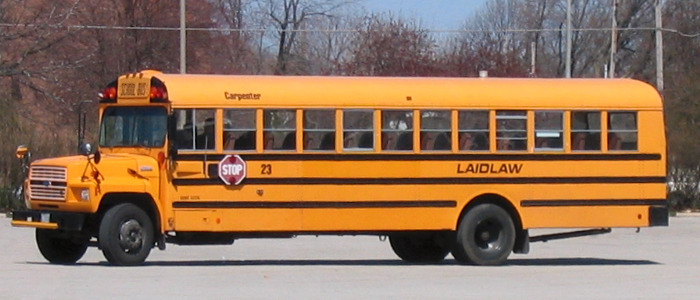

In [10]:
img

In [11]:
# preprocess image
img_resized = img.resize((227, 227))
img_array = np.asarray(img_resized).astype(np.float32, copy=True)
img_array = img_array[:, :, ::-1]  # color to BGR order
img_array -= [103.939, 116.779, 123.68]  # subtract dataset mean for each channel
img_array = np.transpose(img_array, (2, 0, 1))  # data order to channel, height, width
img_array = img_array[np.newaxis, :, :, :]  # sample, channel, height, width
img_array.shape

(1, 3, 227, 227)

In [12]:
np.save("data/school_bus.npy", img_array)

## Convert model with example input
You can specify numpy array file instead of shape information.
Converted model itself is same.

In [13]:
!python ../../bin/convert_caffe.py --input_name data --input_npy data/school_bus.npy --output_names fc8 --out output data/bvlc_reference_caffenet.caffemodel

/Users/kikura/.anyenv/envs/pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[convert_caffe] Loading caffe model... (usually takes several minutes)
[convert_caffe] Generating feedforward graph
/Users/kikura/workspace/webdnn/src/graph_transpiler/webdnn/util/console.py:30: Warning: [ChainerConverter] Dropout is ignored
  warnings.warn(message, category)
[convert_caffe] Generating descriptors


## Observing output
The output array corresponding to example input is saved.

In [14]:
dnn_output = np.load("output/example_output.npz")  # read output of DNN given input array
fc8 = dnn_output["fc8"]
fc8[0, :10]  # prediction scores for each label

array([ -4.7230926,  -1.194076 ,  -1.139904 ,  -9.219471 ,  -4.2670135,
        -6.994253 , -10.601347 ,   2.1703908,  -0.4967225,  -2.7954774],
      dtype=float32)

In [15]:
np.argsort(-fc8[0, :])[:5]  # display top5 label numbers

array([779, 705, 408, 517, 654])

Human-readable label meanings:
https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a#file-imagenet1000_clsid_to_human-txt

It says 779="school bus", 705="passenger car". Does it match model's prediction?